In [11]:
# import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary

In [12]:
# Check for a CUDA device (GPU)
use_cuda = torch.cuda.is_available()
# Selects the device based on GPU availability between CPU & GPU
device = torch.device("cuda" if use_cuda else "cpu")
# Displays the available device
device

device(type='cuda')

In [13]:

# Number of images to process at once in a mini-batch
batch_size = 1024

# Gives us the DataLoader object which is an iterator over the MNIST dataset and
# gives batches of batch_size. It is also responsible for shuffling the dataset
# The transforms used are conversion of array to tensor and normalization to fixed
# distribution (given by the mean and std. dev.)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True)

# Some Notes on our naive model

We are going to write a network based on what we have learnt so far.

The size of the input image is 28x28x1. We are going to add as many layers as required to reach RF = 32 "atleast".

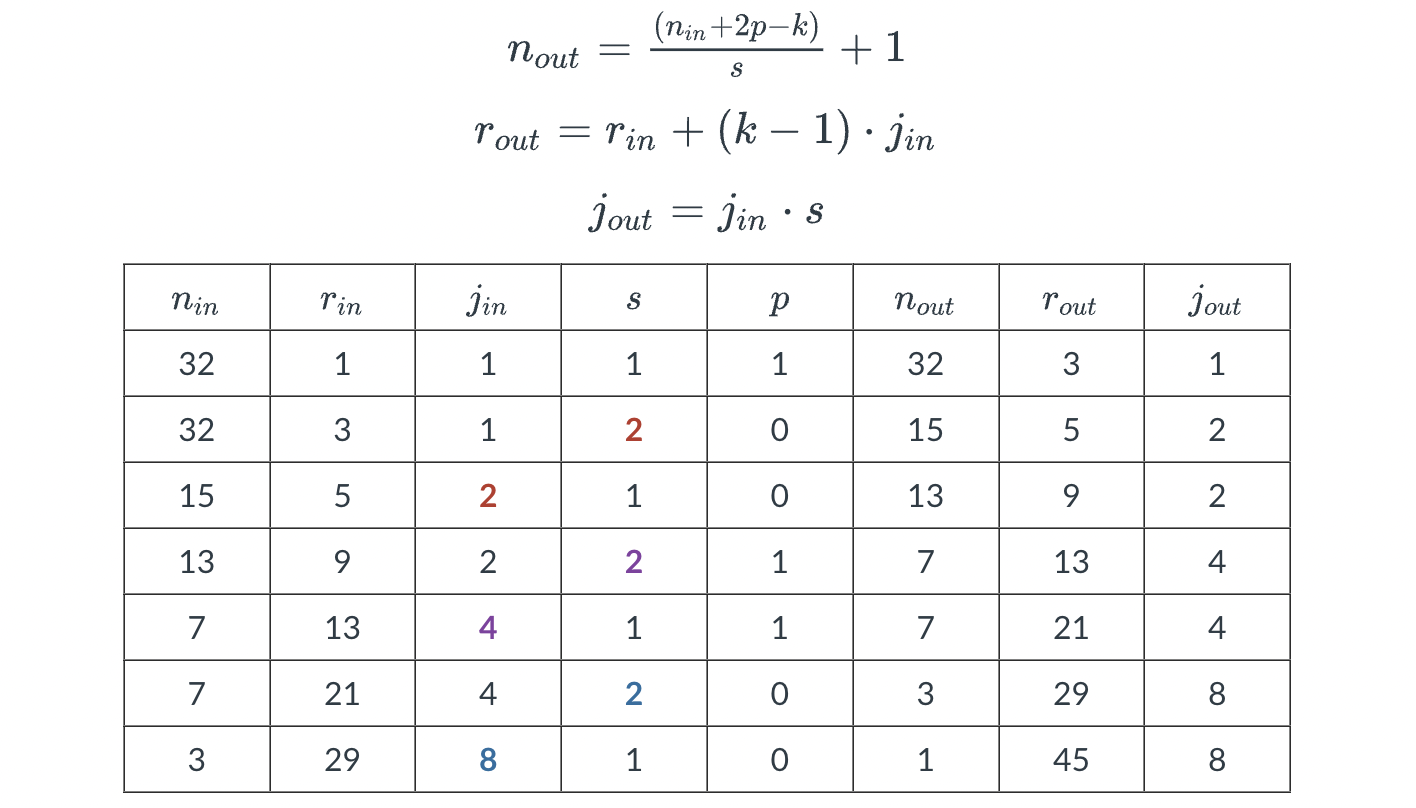

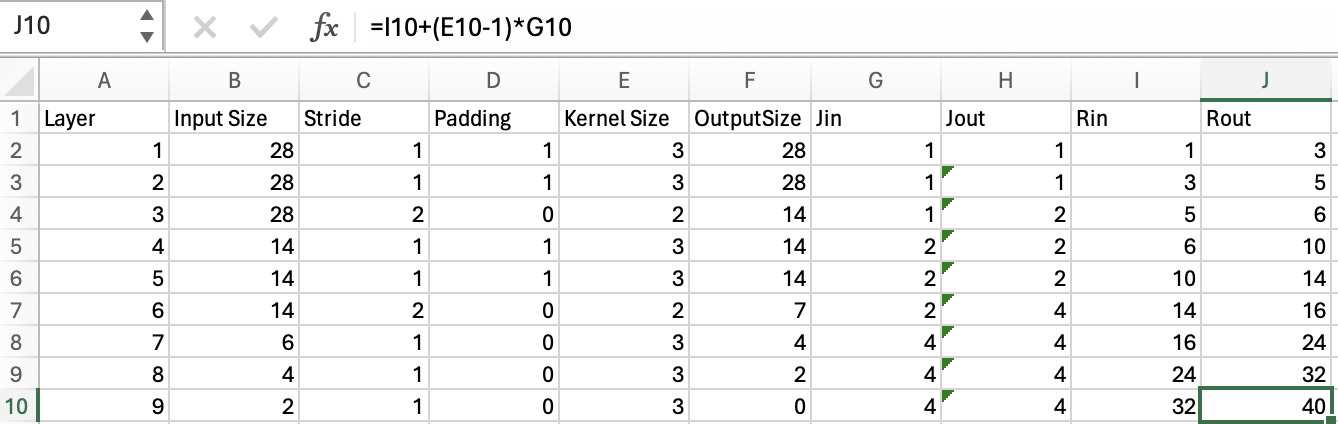

In [14]:

"""
FirstDNN class inherited from the nn.Module class which is used for defining
the pyTorch CNN model.
"""

class FirstDNN(nn.Module):
  # The initializer for the class contains the model layers with different parameters
  # This is reponsible for initializing the model parameters when the model object
  # is instantiated
  def __init__(self):
    super(FirstDNN, self).__init__()

    # r_in - Input receptive field
    # n_in - Number of input features
    # j_in - Input jump or representation power of pixels, initializes with 1 on first layer
    # s - stride
    # r_out - Output receptive field, calculated as (r_in + (k-1)*j_in)
    # n_out - Number of output features, calculated as (((n_in + 2*p - k)/s) + 1)
    # j_out - Output jump or representation power of pixels, calculated as j_in * s

    # First layer: convolution
    # This is a 2d Convolution layer with parameters as
    #(in_channels = 1, out_channels (No. of filters) = 32, kernel_size = 3x3, padding = 1)
    # r_in:1, n_in:28, j_in:1, s:1, r_out:3, n_out:28, j_out:1
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)

    # Second layer: convolution
    # r_in:3 , n_in:28 , j_in:1 , s:1 , r_out:5 , n_out:28 , j_out:1
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

    # Third layer: Max Pooling
    # 2d MaxPooling layer with parameters as (kernel_size=2, stride=2)
    # r_in:5 , n_in:28 , j_in:1 , s:2 , r_out:6 , n_out:14 , j_out:2
    self.pool1 = nn.MaxPool2d(2, 2)

    # Fourth layer: convolution
    # r_in:6 , n_in:14 , j_in:2 , s:1 , r_out:10 , n_out:14 , j_out:2
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

    # Fifth layer: convolution
    # r_in:10 , n_in:14 , j_in:2 , s:1 , r_out:14 , n_out:14 , j_out:2
    self.conv4 = nn.Conv2d(128, 256, 3, padding = 1)

    # Sixth layer: Max Pooling
    # These layers do not have a padding now (padding=0 default!)
    # r_in:14 , n_in:14 , j_in:2 , s:2 , r_out:16 , n_out:7 , j_out:4
    self.pool2 = nn.MaxPool2d(2, 2)

    # Seventh layer: convolution
    # r_in:16 , n_in:7 , j_in:4, s:1 , r_out:24 , n_out:5 , j_out:4
    self.conv5 = nn.Conv2d(256, 512, 3)

    # Eighth layer: convolution
    # r_in:24 , n_in:5 , j_in:4 , s:1 , r_out:32 , n_out:3 , j_out:4
    self.conv6 = nn.Conv2d(512, 1024, 3)

    # Nineth layer: convolution
    # r_in:32 , n_in:3 , j_in:4 , s:1 , r_out:40 , n_out:1 , j_out:4
    self.conv7 = nn.Conv2d(1024, 10, 3)

# Correct values
# https://user-images.githubusercontent.com/498461/238034116-7db4cec0-7738-42df-8b67-afa971428d39.png


  # ForwardPass method of the model
  # Used to obtain output of a model given the current state and input
  def forward(self, x):
    # The input x is fed into conv1 layer followed by a relu non-linearity
    # Followed by conv2 -> relu -> pool1 -> conv3 -> relu -> conv4 -> relu -> pool2
    # Followed by conv7 -> relu -> flatten -> log_softmax (A non-linearity with normalization benefits)
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = F.relu(self.conv6(F.relu(self.conv5(x))))
    x = self.conv7(x)
    x = F.relu(x) # this is the last step. Think what ReLU does to our results at this stage!  -> Adding Non linearity
    x = x.view(-1, 10)
    return F.log_softmax(x)


In [15]:

# Send the model to the current device
model = FirstDNN().to(device)

In [16]:

# Print the summary of the model
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

<ipython-input-14-1962f6fdb10d>:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [17]:
from tqdm import tqdm
"""
Train method responsible for training (weight optimization) of the input
model object

Inputs:
model: model object
device: current device
train_loader: train dataloader object
optimizer: optimization method used for NN training
epoch: Current epoch number
"""
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to train (changes behaviour of various layers like batch-norm)
    model.train()
    # Progress bar using tqdm python module
    pbar = tqdm(train_loader)
    # Get the (data, target) batch tuple from train_loader with index as batch_idx
    for batch_idx, (data, target) in enumerate(pbar):
      # Send the data and target to the current device, necessary for communication with the model
        data, target = data.to(device), target.to(device)
        # Clear previous gradients before new gradient computation as optimizer tends to
        # accumulate gradients by default
        optimizer.zero_grad()
        # Perform the forward pass on the dataset, getting the model outputs for the inputs
        output = model(data)
        # Compare the computed outputs with the target using the NLL (Negative Log Likelihood, multi-class classification loss) fxn
        # This returns the loss per input in the batch
        loss = F.nll_loss(output, target)
        # Computed the model weight update gradients (dL/dW) using the loss computed in the previous step
        loss.backward()
        # Performs the weight update (Wnew = Wold - alpha*(dL/dWold))
        optimizer.step()
        # Prints the progress of the training given by the loss values per batch
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

"""
Test method responsible for inference on the learnt model parameters

Inputs:
model: model object
device: current device
test_loader: test dataloader object (data to be tested upon)
"""
def test(model, device, test_loader):
    # Set the model to eval mode (changes behaviour of various layers like batch-norm)
    model.eval()
    # Initialize the global test loss to zero
    test_loss = 0
    # Initialize global correct examples to zero (Used for accuracy calc)
    correct = 0
    # We explicitly tell pytorch to not compute the gradient to save compute!
    with torch.no_grad():
        # Get the (data, target)batch tuple from the loader
        for data, target in test_loader:
            # Send the data and target to the current device, necessary for communication with the model
            data, target = data.to(device), target.to(device)
            # Perform the forward pass on the dataset, getting the model outputs for the inputs
            output = model(data)
            # Compare the computed outputs with the target using the NLLfxn
            # The reduction method specifies summing the loss values for all the examples in the batch
            # Finally the item() method specifies to just get the loss value from the tensor object
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            # Get the predicted output from the maximum probable output
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # Compare the predictions with the target to get the number of correct examples
            correct += pred.eq(target.view_as(pred)).sum().item()
    # Normalize the test loss with the length of the dataset
    test_loss /= len(test_loader.dataset)
    # Print the test stats - Loss and Accuracy (No. of correct normalized by total number)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [18]:
# Create an instance of the stochastic gradient descent optimizer
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
# lr is the learning rate which controls the step size of the optimizer
# momentum is a parameter that controls the amount of inertia in the optimizer i.e. how much the previous step affects the current step

# Initialize the optimization method for the model parameters. The learning rate
# is specified to 0.01 with a momentum of 0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Run the training and testing for one epoch
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/59 [00:00<?, ?it/s]<ipython-input-14-1962f6fdb10d>:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=1.2921589612960815 batch_id=58: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]



Test set: Average loss: 1.6628, Accuracy: 5540/10000 (55%)



loss=1.5228561162948608 batch_id=58: 100%|██████████| 59/59 [00:31<00:00,  1.85it/s]



Test set: Average loss: 1.4695, Accuracy: 3960/10000 (40%)



loss=1.4247454404830933 batch_id=58: 100%|██████████| 59/59 [00:28<00:00,  2.09it/s]



Test set: Average loss: 1.4250, Accuracy: 4060/10000 (41%)



loss=1.4741716384887695 batch_id=58: 100%|██████████| 59/59 [00:31<00:00,  1.86it/s]



Test set: Average loss: 1.4032, Accuracy: 4095/10000 (41%)



loss=1.4187110662460327 batch_id=58: 100%|██████████| 59/59 [00:30<00:00,  1.96it/s]



Test set: Average loss: 1.3953, Accuracy: 4105/10000 (41%)



loss=1.3791539669036865 batch_id=58: 100%|██████████| 59/59 [00:29<00:00,  2.01it/s]



Test set: Average loss: 1.3879, Accuracy: 4120/10000 (41%)



loss=1.4076875448226929 batch_id=58: 100%|██████████| 59/59 [00:28<00:00,  2.07it/s]



Test set: Average loss: 1.3762, Accuracy: 4137/10000 (41%)



loss=1.3427033424377441 batch_id=58: 100%|██████████| 59/59 [00:28<00:00,  2.08it/s]



Test set: Average loss: 1.3739, Accuracy: 4141/10000 (41%)



loss=1.3924851417541504 batch_id=58: 100%|██████████| 59/59 [00:28<00:00,  2.06it/s]



Test set: Average loss: 1.3724, Accuracy: 4142/10000 (41%)



In [19]:
# experiment 1
class FirstDNN(nn.Module):
  def __init__(self):
    super(FirstDNN, self).__init__()
    # r_in:1, n_in:28, j_in:1, s:1, r_out:3, n_out:28, j_out:1
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.pool1 = nn.MaxPool2d(2, 2)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv4 = nn.Conv2d(32, 32, 3, padding = 1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.pool2 = nn.MaxPool2d(2, 2)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv5 = nn.Conv2d(32, 32, 3)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv6 = nn.Conv2d(32, 32, 3)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv7 = nn.Conv2d(32, 10, 3)
# Correct values
# https://user-images.githubusercontent.com/498461/238034116-7db4cec0-7738-42df-8b67-afa971428d39.png
  def forward(self, x):
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = F.relu(self.conv6(F.relu(self.conv5(x))))
    x = self.conv7(x)
    x = F.relu(x) # this is the last step. Think what ReLU does to our results at this stage!
    x = x.view(-1, 10)
    return F.log_softmax(x)


model = FirstDNN().to(device)
summary(model, input_size=(1, 28, 28))

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 2):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

<ipython-input-19-1657cd7ef3b9>:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
            Conv2d-5           [-1, 32, 14, 14]           9,248
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 32, 5, 5]           9,248
            Conv2d-8             [-1, 32, 3, 3]           9,248
            Conv2d-9             [-1, 10, 1, 1]           2,890
Total params: 49,450
Trainable params: 49,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 0.19
Estimated Total Size (MB): 0.74
---------------------------------------------

loss=2.2975175380706787 batch_id=58: 100%|██████████| 59/59 [00:20<00:00,  2.83it/s]



Test set: Average loss: 2.2965, Accuracy: 1030/10000 (10%)



In [ ]:
# experiment 2
class FirstDNN(nn.Module):
  def __init__(self):
    super(FirstDNN, self).__init__()
    # r_in:1, n_in:28, j_in:1, s:1, r_out:3, n_out:28, j_out:1
    self.conv1 = nn.Conv2d(1, 128, 3, padding=1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.pool1 = nn.MaxPool2d(2, 2)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.pool2 = nn.MaxPool2d(2, 2)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv5 = nn.Conv2d(128, 128, 3)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv6 = nn.Conv2d(128, 128, 3)
    # r_in: , n_in: , j_in: , s: , r_out: , n_out: , j_out:
    self.conv7 = nn.Conv2d(128, 10, 3)
# Correct values
# https://user-images.githubusercontent.com/498461/238034116-7db4cec0-7738-42df-8b67-afa971428d39.png
  def forward(self, x):
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = F.relu(self.conv6(F.relu(self.conv5(x))))
    x = self.conv7(x)
    x = F.relu(x) # this is the last step. Think what ReLU does to our results at this stage!
    x = x.view(-1, 10)
    return F.log_softmax(x)

model = FirstDNN().to(device)
summary(model, input_size=(1, 28, 28))

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 2):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)